<p style="text-align: center; font-size: 35px;"><b>Social Media Management</b></p>
<p style="margin-top: -20px; text-align: center; font-size: 27px;"><b>Twitter APIs Tutorial</b></p>
<p style="margin-top: -10px; text-align: center; font-size: 20px;"><b>Analysis of the Use of Twitter by Italian Politicians</b></p>


## Introduction

Twitter is a social networking service - launched on July 2006 - on which users post and interact with messages known as 'tweets'. Registered users can post, like, retweet, and comment other users tweets. Unregistered users can just read public tweets. 

Users can interact with Twitter in two different ways: the user-friendly interface (web or mobile version) or programmatically via its APIs. Twitter is also recognized for having one of the most open developer APIs.<br/>
For any additional information you can visit the web page https://developer.twitter.com/en.

The main focus of this tutorial is to get italian politicians data and make stats about them.<br/>
Probably, Twitter is the best platform to fetch this data because it's the most used by politicians to write about politic. 

## Source Code

First, you have to import all the modules you need:
- ``twitter`` provides a pure Python interface for the Twitter API.
- ``requests`` allows to send HTTP requests in a very easy way.
- ``numpy`` adds support for big arrays and matrices, along with a large collection of math functions.
- ``pandas`` helps with data manipulation and analysis through charts and tables.

In [1]:
import twitter
import requests

import numpy as np
import pandas as pd

from dateutil import parser
from datetime import datetime, timedelta

Then, you should set a group of constants with your keys value.

In [2]:
CONSUMER_KEY = '...'
CONSUMER_SECRET = '......'
ACCESS_TOKEN_KEY = '......'
ACCESS_TOKEN_SECRET = '.........'
BEARER_TOKEN = '.....................'

For convenience, to write a more readble code, I implemented a set of methods useful to work with dates.

In [3]:
def checkIsoByDate(t, n):
    return abs((parser.parse(t[:-1]) - datetime.now()).days) <= n

def convertToIso(t):
    return t.isoformat("T") + "Z"
    
def removeMicroseconds(t):
    return t.replace(microsecond=0)
    
def withinDays(n):
    return convertToIso(removeMicroseconds(datetime.now() - timedelta(days = n)))

def withinWeeks(n):
    return convertToIso(removeMicroseconds(datetime.now() - timedelta(weeks = n)))

def withinDate(date):
    return convertToIso(datetime.strptime(date, '%Y-%m-%d %H:%M:%S.%f'))

Additionally, I created a set of classes to make a good code (readble and reliable).

**TwitterAPI** &#8594; Implements methods for connection, authentication, and for fetch users and tweets data. All via REST APIs.
- ``getUserByHandle(handle)`` &#8594; Gets user info by his handle (*e.g. @JohnDoe*).
- ``getUserById(id)`` &#8594; Gets user info by its id (*e.g. 1234*).
- ``getTweetsById(id)`` &#8594; Gets user tweets by its id (*e.g. 1234*). Furthermore, Twitter allows us to gets only tweets which respects the entire set of parameters. They can be many, but in this case we have chosen:
    - **max_results** **∈ [5, 100] per distinct request**, specifies the number of Tweets to try and retrieve.
    - **tweet.fields** enables developers to select which specific Tweet fields (except *id* and *text*) will deliver in each returned Tweet object (*e.g. likes, retweets, etc*).
    - **start_time** specifies we want to retrieve just tweets posted after a specific date.

In [4]:
class TwitterAPI:

    def __init__(self):
        self.api = twitter.Api(CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN_KEY, ACCESS_TOKEN_SECRET)
    
    def getTweetsById(self, id):
        headers = { 'Authorization': "Bearer " + BEARER_TOKEN }
        params = (
            ('max_results', '100'),
            ('tweet.fields', 'public_metrics,created_at'),
            ('start_time', withinWeeks(1))
        )
        
        response = requests.get(f'https://api.twitter.com/2/users/{id}/tweets', headers=headers, params=params)
        return response.json()
    
    def getUserByHandle(self, username):
        return self.api.GetUser(screen_name=username)
    
    def getUserById(self, id):
        return self.api.GetUser(user_id=id)

**Politician** &#8594; Represents the entity of the Politician. It only provides methods for obtaining info from a politician tweets
- ``__getTweets()`` &#8594; Is a private method. Returns to other methods a list of Tweet objects.
- ``getNumberOfTweets()`` &#8594; Returns the number of tweets retrieved.
- ``getSumOfTextLength()`` &#8594; Sums the length of all tweet texts.
- ``getSumOfMetric(metric)`` &#8594; Based on the parameter, it sums the values of a specific tweet metric (e.g. sum of all likes).
- ``getTweetsFromYesterday()`` &#8594; Returns the number of tweets posted within 24 hours.
- ``getTweetsFromWeek()`` &#8594; Returns the number of tweets posted within 7 days.
- ``hasTweets()`` &#8594; Checks if the politician has posted some tweets.
- ``setTweets(info)`` &#8594; Associates the tweets to the politician.

In [5]:
class Politician:
    
    def __init__(self, info):
        self.description = info.description
        self.followers = info.followers_count
        self.following = info.friends_count
        self.handle = info.screen_name
        self.id = info.id_str
        self.name = info.name

    def __getTweets(self):
        return self.__tweets['data']
        
    def getNumberOfTweets(self):
        return self.__tweets['meta']['result_count']    

    def getSumOfTextLength(self):
        return sum(len(tweet['text']) for tweet in self.__getTweets())

    def getSumOfMetric(self, metric):
        return sum(tweet['public_metrics'][metric] for tweet in self.__getTweets())

    def getTweetsFromYesterday(self):
        return sum(checkIsoByDate(tweet['created_at'], 1) for tweet in self.__getTweets())

    def getTweetsFromWeek(self):
        return sum(checkIsoByDate(tweet['created_at'], 7) for tweet in self.__getTweets())
    
    def hasTweets(self):
        return self.getNumberOfTweets() > 0
    
    def setTweets(self, tweets):
        self.__tweets = tweets

In Italy we have mainly two political orientation: Left and Right.
- **Left** is the component of the Parliament that sits to the left of the President of the Legislative Assembly and, in general, the set of political positions qualified as progressive and egalitarian.
- **Right** is the component of the Parliament that sits to the right of the President of the Legislative Assembly and, in general, the set of political positions qualified as conservatives and nationalists.

At the moment, there are two main parties which represent the Left wing: **Democratic Party** and **Five Star Movement**; and three main parties which represent the Right wing: **Brothers of Italy**, **Northern League**, **Forward Italy**.

**PoliticalWing** &#8594; Represents the entity of the Political Wing (political orientation) and collect their respective politicians. It only provides methods of obtaining statistics from a set of politicians tweets.
- ``__getAvg()`` &#8594; Is a private method. Based on the parameter, it calculates the average of a set of info of the politicians tweets.
- ``getAvgLikes()`` &#8594; Returns the average number of likes.
- ``getAvgReplies()`` &#8594; Returns the average number of replies.
- ``getAvgRetweets()`` &#8594; Returns the average number of retweets.
- ``getAvgQuotes()`` &#8594; Returns the average number of quotes.
- ``getAvgTweetsLen()`` &#8594; Returns the average length of tweets.
- ``getTotalFollowers()`` &#8594; Returns the sum of the followers of each politician.
- ``getTweetsPerDay()`` &#8594; Returns the number of tweets posted by all politicans within a day.
- ``getTweetsPerWeek()`` &#8594; Returns the number of tweets posted by all politicans within a week.
- ``insertPolitician()`` &#8594; Inserts a new politician into the set

In [6]:
class PoliticalWing:

    def __init__(self):
        self.__politicians = set()
    
    def __getAvg(self, metric=None):
        avg = 0
        
        for p in self.__politicians:
            if p.hasTweets():
                summation = p.getSumOfTextLength() if metric is None else p.getSumOfMetric(metric)
                avg += summation / p.getNumberOfTweets()
                
        return avg // len(self.__politicians)
    
    def getAvgLikes(self):
        return self.__getAvg('like_count')
    
    def getAvgReplies(self):
        return self.__getAvg('reply_count')
    
    def getAvgRetweets(self):
        return self.__getAvg('retweet_count')
    
    def getAvgQuotes(self):
        return self.__getAvg('quote_count')

    def getAvgTweetsLen(self):
        return self.__getAvg()

    def getTotalFollowers(self):
        return sum(p.followers for p in self.__politicians)
    
    def getTweetsPerDay(self):
        return sum(p.getTweetsFromYesterday() for p in self.__politicians if p.hasTweets())

    def getTweetsPerWeek(self):
        return sum(p.getTweetsFromWeek() for p in self.__politicians if p.hasTweets())

    def insertPolitician(self, p):
        self.__politicians.add(p)

## Data Extraction
Once declared all classes, we can fetch data.

First, we connect and authenticate. Then, we read all the names of left-wing and right-wing politicians from their respective text files. After that, we retrieve the information and tweets of each politician to insert it within the respective PoliticalWing object.

In [7]:
api = TwitterAPI()

left = PoliticalWing()
right = PoliticalWing()

left_file = open('texts/left.txt', 'r')
right_file = open('texts/right.txt', 'r')

left_handles = left_file.readlines()
right_handles = right_file.readlines()

left_file.close()
right_file.close()

for pHandle in left_handles:
    pLeft = Politician(api.getUserByHandle(pHandle))
    pLeft.setTweets(api.getTweetsById(pLeft.id))
    left.insertPolitician(pLeft)
    
for pHandle in right_handles:
    pRight = Politician(api.getUserByHandle(pHandle))
    pRight.setTweets(api.getTweetsById(pRight.id))
    right.insertPolitician(pRight)

## Data Analysis and Statistics

Now we will be working and displaying data:
- a table to display all stats (it is useful for checking calculations).
- a pie chart to visualize the difference between the number of tweets per day posted by Left-Wing and Right-Wing politicians.
- a bar graphic to visualize all weighted statistics by the total number of tweets.
- a bar graphic to visualize all weighted statistics by the total number of tweets and the respective number of followers.

In [8]:
dataForStatsTable = {
    'Total Followers': [left.getTotalFollowers(), right.getTotalFollowers()],
    'Tweets Per Day': [left.getTweetsPerDay(), right.getTweetsPerDay()],
    'Tweets Per Week': [left.getTweetsPerWeek(), right.getTweetsPerWeek()],
    'AVG Likes': [left.getAvgLikes(), right.getAvgLikes()],
    'AVG Retweets': [left.getAvgRetweets(), right.getAvgRetweets()],
    'AVG Replies': [left.getAvgReplies(), right.getAvgReplies()],
    'AVG Quotes': [left.getAvgQuotes(), right.getAvgQuotes()],
    'AVG Tweets Length': [left.getAvgTweetsLen(), right.getAvgTweetsLen()],
 }

statsTable = pd.DataFrame(dataForStatsTable, index = ['Left', 'Right'])
statsTable

,Total Followers,Tweets Per Day,Tweets Per Week,AVG Likes,AVG Retweets,AVG Replies,AVG Quotes,AVG Tweets Length
Left,2719411,9,110,518.0,91.0,137.0,12.0,181.0
Right,2664734,5,50,804.0,110.0,396.0,26.0,207.0


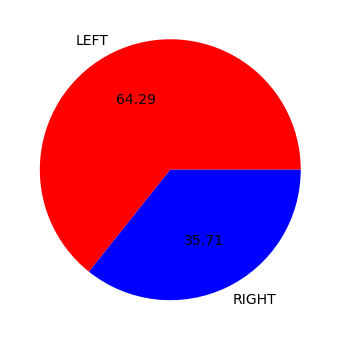

In [9]:
dataChart = np.array([ left.getTweetsPerDay(), right.getTweetsPerDay() ])
s = pd.Series(dataChart, name = '')

s.plot.pie (
    labels = ['LEFT', 'RIGHT'],
    colors = ['r', 'b'],
    autopct = "%.2f",
    fontsize = 14,
    figsize = (6, 6),
);

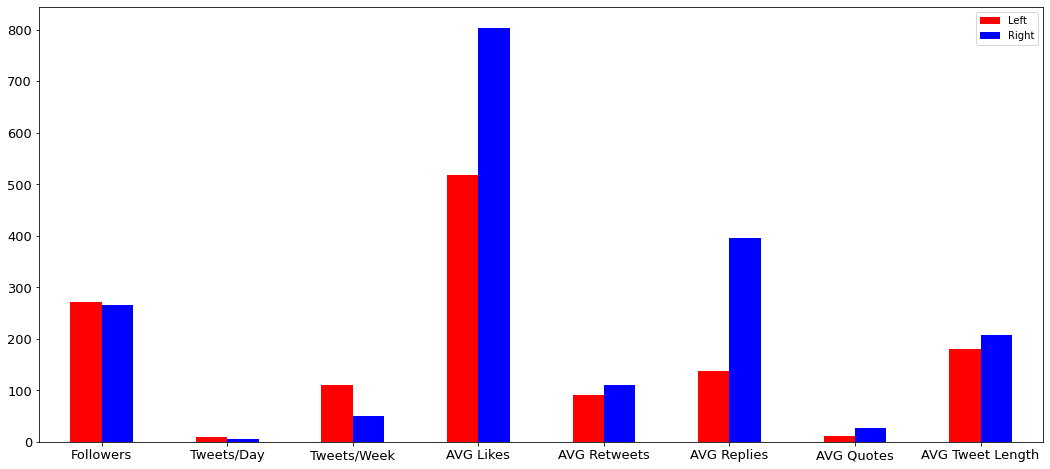

In [10]:
left_data = [
    left.getTotalFollowers() / 10000,
    left.getTweetsPerDay(),
    left.getTweetsPerWeek(),
    left.getAvgLikes(),
    left.getAvgRetweets(),
    left.getAvgReplies(),
    left.getAvgQuotes(),
    left.getAvgTweetsLen()
]

right_data = [
    right.getTotalFollowers() / 10000,
    right.getTweetsPerDay(),
    right.getTweetsPerWeek(),
    right.getAvgLikes(),
    right.getAvgRetweets(),
    right.getAvgReplies(),
    right.getAvgQuotes(),
    right.getAvgTweetsLen()
]

indexData = [
    'Followers',
    'Tweets/Day',
    'Tweets/Week',
    'AVG Likes',
    'AVG Retweets',
    'AVG Replies',
    'AVG Quotes',
    'AVG Tweet Length'
]

graphic = pd.DataFrame({'Left': left_data, 'Right': right_data}, index=indexData)
graphic.plot.bar(color=['r', 'b'], fontsize = 13, figsize=(18,8), rot=0);

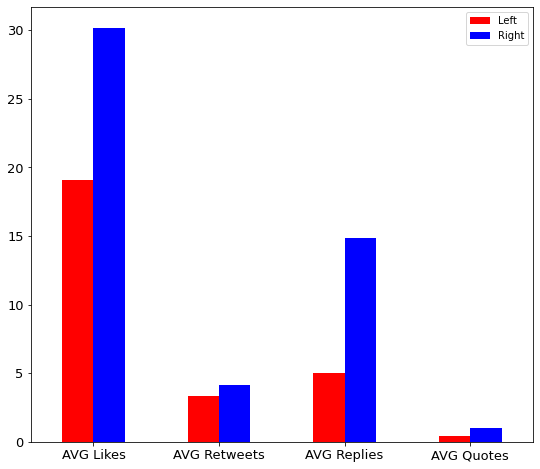

In [11]:
left_weighted_data = [
    (left.getAvgLikes() / left.getTotalFollowers()) * 100000,
    (left.getAvgRetweets() / left.getTotalFollowers()) * 100000,
    (left.getAvgReplies() / left.getTotalFollowers()) * 100000,
    (left.getAvgQuotes() / left.getTotalFollowers()) * 100000
]

right_weighted_data = [
    (right.getAvgLikes() / right.getTotalFollowers()) * 100000,
    (right.getAvgRetweets() / right.getTotalFollowers()) * 100000,
    (right.getAvgReplies() / right.getTotalFollowers()) * 100000,
    (right.getAvgQuotes() / right.getTotalFollowers()) * 100000
]

indexWeightedData = [
    'AVG Likes',
    'AVG Retweets',
    'AVG Replies',
    'AVG Quotes'
]

graphic_w = pd.DataFrame({'Left': left_weighted_data, 'Right': right_weighted_data}, index=indexWeightedData)
graphic_w.plot.bar(color=['r', 'b'], fontsize = 13, figsize=(9,8), rot=0);

For what we have just seen, we can say that:
- **Left-Wing** politicians are the ones who write more text in their tweets. Moreover, their voters are not as present and active as the Right-Wing voters.
- **Right-Wing** politicians are the ones who post more tweets. Probably, they are also the ones who invest the most in Social Media Management. Like the famous "La Bestia" (The Beast) of Matteo Salvini and of his party.

## Conclusion and Future Works
To sum up: in my experience Twitter has an excellent APIs system, a great developer portal, and an extensive documentation (documentation, library tools, tutorials, etc.). They provide also an efficient developers community. In my opinion, a great feature of Twitter APIs, is that they are free and allows developers to retreive almost any data - obviously there are a little bit of restrictions available just by premium accounts.
